# Imports

In [10]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC

# Data

In [11]:
df = pd.read_csv('../0_data/DEvideos.csv')

df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

# Add additional Data
df['ratings'] = df['likes'] + df['dislikes']
df['likes_per_rating'] = df.apply(lambda row: 0 if row['ratings'] == 0 else row['likes'] / row['ratings'], axis=1)
df['ratings_per_view'] = df['ratings'] / df['views']
df['comments_per_view'] = df['comment_count'] / df['views']

dropColumns = ['video_id', 'title', 'thumbnail_link', 'description']
df.drop(columns=dropColumns, inplace=True)

df.head()

,trending_date,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,days_until_trending,ratings,likes_per_rating,ratings_per_view,comments_per_view
0,2017-11-14,inscope21,24,2017-11-13 17:08:49,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",252786,35885,230,1539,False,False,False,1,36115,0.993631,0.142868,0.006088
1,2017-11-14,LUKE! Die Woche und ich,23,2017-11-12 22:30:01,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",797196,53576,302,1278,False,False,False,2,53878,0.994395,0.067584,0.001603
2,2017-11-14,LastWeekTonight,24,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97190,6146,12703,False,False,False,1,103336,0.940524,0.042722,0.005252
3,2017-11-14,100SekundenPhysik,27,2017-11-12 15:00:01,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",380247,31821,458,1955,False,False,False,2,32279,0.985811,0.084890,0.005141
4,2017-11-14,rezo,24,2017-11-12 13:10:36,"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",822213,100684,2467,10244,False,False,False,2,103151,0.976084,0.125455,0.012459


## Add days_until_trending as target category

In [12]:
def assign_target_category(row):
    if row['days_until_trending'] == 0:
        return '0 Days'
    elif row['days_until_trending'] == 1:
        return '1 Day'
    elif row['days_until_trending'] == 2:
        return '2 Days'
    elif row['days_until_trending'] < 10:
        return '< 10 Days'
    elif row['days_until_trending'] < 100:
        return '< 100 Days'
    elif row['days_until_trending'] < 1000:
        return '< 1000 Days'
    else:
        return '>= 1000 Days'

df['target_category'] = df.apply(assign_target_category, axis=1)

df.head()

df.dtypes

trending_date             datetime64[ns]
channel_title                     object
category_id                        int64
publish_time              datetime64[ns]
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
comments_disabled                   bool
ratings_disabled                    bool
video_error_or_removed              bool
days_until_trending                int64
ratings                            int64
likes_per_rating                 float64
ratings_per_view                 float64
comments_per_view                float64
target_category                   object
dtype: object

# Model training and fitting

In [13]:
# Use multiple columns
#x = pd.DataFrame(df.iloc[:, 5:8])
# Use single column
x = pd.DataFrame(df[['views']])
y = pd.DataFrame(df['target_category']).values.ravel()

x = preprocessing.scale(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = SVC(kernel='rbf', random_state = 1)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.633692458374143

## Prediction (value is depending from chosen feature)

In [14]:
model.predict([[45000]])

array(['< 10 Days'], dtype=object)

# Plot the data

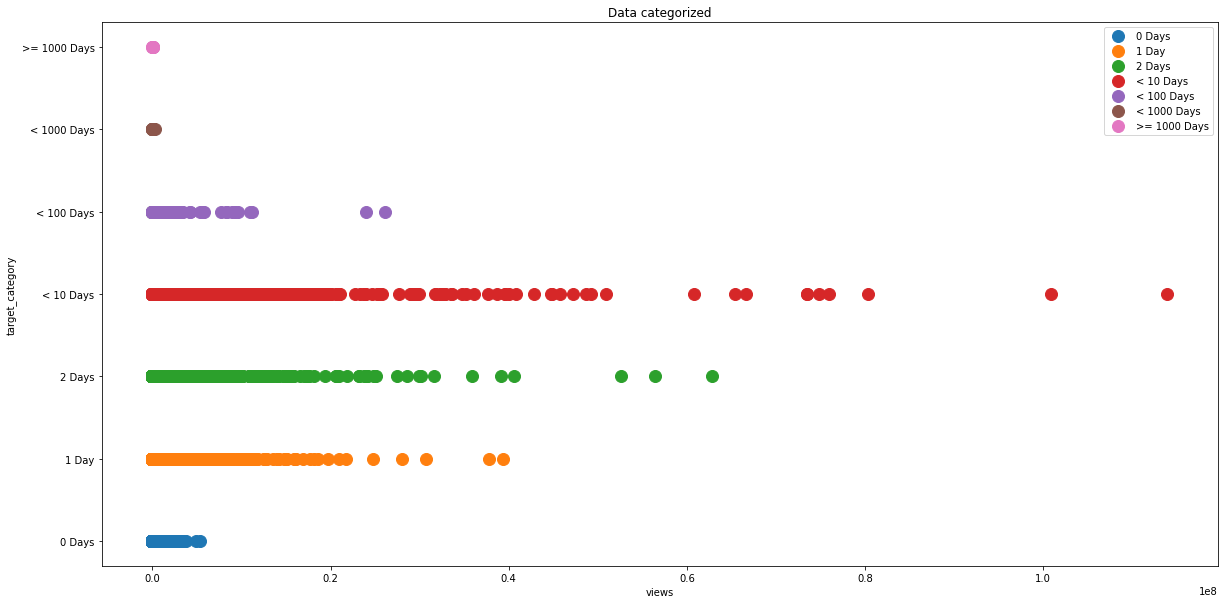

In [15]:
plt.figure(figsize=(20, 10))
plt.title('Data categorized')
plt.xlabel('views')
plt.ylabel('target_category')
groups = df.groupby('target_category')
for name, group in groups:
    plt.plot(group.views, group.target_category, marker='o', linestyle='', markersize=12, label=name)

plt.legend()
